# Основы глубинного обучения, майнор ИАД

## Домашнее задание 1. Введение в PyTorch. Полносвязные нейронные сети.

### О задании

В этом задании вам предстоит предсказывать год выпуска песни по некоторым звуковым признакам: [данные](https://archive.ics.uci.edu/ml/datasets/yearpredictionmsd). В ячейках ниже находится код для загрузки данных. Обратите внимание, что обучающая и тестовая выборки располагаются в одном файле, поэтому НЕ меняйте ячейку, в которой производится деление данных.

In [1]:
import sys
import torch
from torch import nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import random
from tqdm import tqdm
from IPython.display import clear_output
from sklearn.metrics import mean_squared_error

In [3]:
torch.cuda.is_available()

True

In [4]:
# !wget -O data.txt.zip https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip

In [6]:
# from google.colab import drive
# drive.mount('/content/drive')

In [5]:
# df = pd.read_csv('drive/MyDrive/colab_notebooks/datasets/data.txt.zip', header=None)
df = pd.read_csv('../input/hse-hw-1/YearPredictionMSD.txt', header=None)
print(df.shape)
df.head()

(515345, 91)


,0,1,2,3,4,5,6,7,8,9,...,81,82,83,84,85,86,87,88,89,90
0,2001,49.94357,21.47114,73.07750,8.74861,-17.40628,-13.09905,-25.01202,-12.23257,7.83089,...,13.01620,-54.40548,58.99367,15.37344,1.11144,-23.08793,68.40795,-1.82223,-27.46348,2.26327
1,2001,48.73215,18.42930,70.32679,12.94636,-10.32437,-24.83777,8.76630,-0.92019,18.76548,...,5.66812,-19.68073,33.04964,42.87836,-9.90378,-32.22788,70.49388,12.04941,58.43453,26.92061
2,2001,50.95714,31.85602,55.81851,13.41693,-6.57898,-18.54940,-3.27872,-2.35035,16.07017,...,3.03800,26.05866,-50.92779,10.93792,-0.07568,43.20130,-115.00698,-0.05859,39.67068,-0.66345
3,2001,48.24750,-1.89837,36.29772,2.58776,0.97170,-26.21683,5.05097,-10.34124,3.55005,...,34.57337,-171.70734,-16.96705,-46.67617,-12.51516,82.58061,-72.08993,9.90558,199.62971,18.85382
4,2001,50.97020,42.20998,67.09964,8.46791,-15.85279,-16.81409,-12.48207,-9.37636,12.63699,...,9.92661,-55.95724,64.92712,-17.72522,-1.49237,-7.50035,51.76631,7.88713,55.66926,28.74903


<AxesSubplot:>

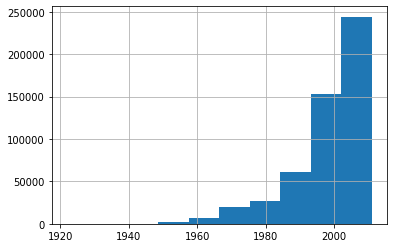

In [6]:
df[0].hist()

In [7]:
# фиксированное трейн/тест разделение
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

train_size = 463715
X_train = X[:train_size, :]
y_train = y[:train_size]
X_test = X[train_size:, :]
y_test = y[train_size:]

In [8]:
X_train.shape

(463715, 90)

In [9]:
X_test.shape

(51630, 90)

## Задание 0

Мы будем использовать RMSE как метрику качества. 

Для самого первого бейзлайна обучите `Ridge` регрессию из `sklearn`. Кроме того, посчитайте качество при наилучшем константном прогнозе.

### Ridge Regression

In [10]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

best_train_constant = sum(y_train)/len(y_train)

model = Ridge()
model.fit(X_train, y_train)

y_pred_test = model.predict(X_test)
y_pred_train = model.predict(X_train)


print(
    f'RMSE on train = {mean_squared_error(y_train, y_pred_train, squared=False)}',
    f'RMSE on test = {mean_squared_error(y_test, y_pred_test, squared=False)}',
    f'RMSE on best constant = {mean_squared_error(y_test, best_train_constant * np.ones(y_test.shape))}',
    sep='\n'
)

# Оптимальное решение в задаче минимизации MSE и RMSE в классе констант – среднее арифметическое

RMSE on train = 9.552822967904056
RMSE on test = 9.510160711373397
RMSE on best constant = 117.77597281228708


### CatBoostRegressor

In [13]:
%%time
from catboost import CatBoostRegressor

model = CatBoostRegressor(loss_function='RMSE')
model.fit(X_train, y_train, verbose=False)

CPU times: user 8min 35s, sys: 1.8 s, total: 8min 37s
Wall time: 4min 38s


In [14]:
y_pred_test = model.predict(X_test)
y_pred_train = model.predict(X_train)


print(
    f'RMSE on train = {mean_squared_error(y_train, y_pred_train, squared=False)}',
    f'RMSE on test = {mean_squared_error(y_test, y_pred_test, squared=False)}',
    sep='\n'
)


RMSE on train = 8.444030702417933
RMSE on test = 8.94532790391481


## Задание 1

Реализуйте обучение и тестирование нейронной сети для предоставленного вам набора данных. Соотношение между полученным значением метрики на тестовой выборке и баллами за задание следующее:

- $\text{RMSE} \le 9.00 $ &mdash; 4 балла
- $\text{RMSE} \le 8.90 $ &mdash; 6 баллов
- $\text{RMSE} \le 8.80 $ &mdash; 8 баллов
- $\text{RMSE} \le 8.75 $ &mdash; 10 баллов

Есть несколько правил, которых вам нужно придерживаться:

- Весь пайплайн обучения должен быть написан на PyTorch. При этом вы можете пользоваться другими библиотеками (`numpy`, `sklearn` и пр.), но только для обработки данных. То есть как угодно трансформировать данные и считать метрики с помощью этих библиотек можно, а импортировать модели из `sklearn` и выбивать с их помощью требуемое качество &mdash; нельзя. Также нельзя пользоваться библиотеками, для которых сам PyTorch является зависимостью.

- Мы никак не ограничиваем ваш выбор архитектуры модели, но скорее всего вам будет достаточно полносвязной нейронной сети.

- Для обучения запрещается использовать какие-либо иные данные, кроме обучающей выборки.

- Ансамблирование моделей запрещено.

In [10]:
def set_random_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

In [11]:
set_random_seed(77)

In [12]:
class MyDataset(torch.utils.data.Dataset):
    
    def __init__(self, x, y):
        self.x = x
        self.y = y
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        return torch.tensor(self.x[idx, :], dtype=torch.float), self.y[idx]

In [13]:
class MyModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        self.linear1 = torch.nn.Sequential(
            torch.nn.Linear(in_features=90, out_features=5000),
            torch.nn.BatchNorm1d(5000),
            torch.nn.PReLU(),
#             torch.nn.Dropout(0.4)
        )     
        self.linear2 = torch.nn.Sequential(
            torch.nn.Linear(in_features=5000, out_features=8000),
#             torch.nn.BatchNorm1d(8000),
            torch.nn.PReLU(),
            torch.nn.Dropout(0.4)
        )
        self.linear3 = torch.nn.Sequential(
            torch.nn.Linear(in_features=8000, out_features=6000),
            torch.nn.BatchNorm1d(6000),
            torch.nn.PReLU(),
#             torch.nn.Dropout(0.2)
        )
#         self.linear4 = torch.nn.Sequential(
#             torch.nn.Linear(in_features=6000, out_features=8000),
# #             torch.nn.BatchNorm1d(4800),
#             torch.nn.SELU(),
#             torch.nn.Dropout(0.4)
#         )
        self.output = torch.nn.Linear(in_features=6000, out_features=1)

    def forward(self, x):
        x = self.linear1(x)
        x = self.linear2(x)
        x = self.linear3(x)
#         x = self.linear4(x)
        
        return self.output(x)

In [14]:
def plot_history(train_history, val_history, title="loss", ylim=None):
    """
    Функция построения графика обучения эпохи.
    - train_history - набор лоссов по всем батчам на всех эпохах
    - val_history - набор средних лоссов по батчам на всех эпохах
    """    
    # подбираем шаг для средних значений val_loss
    steps = list(range(0, len(train_history) + 1, int(len(train_history) / len(val_history))))[1:]
    
    plt.title(title)
    plt.xlabel("train steps")
    plt.grid()
    if ylim:
        plt.ylim(ylim[0],ylim[1])
    
    plt.plot(train_history, label="train", zorder=1)
    plt.scatter(steps, val_history, marker="+", s=180, c="orange", label="val", zorder=2)
    
    plt.legend(loc="best")
    plt.show()

In [15]:
def train_model(model, optimizer, criterion, train_loader, test_loader, n_epochs=5, ylim=None):
    '''
    Функция обучения выбранной модели
    
    Параметры:
        model - модель, унаследованная от torch.nn.Module 
        optimizer - оптимизатор модели
        criterion - функция потерь из torch.nn
        train_loader - тренировочный даталоадер из torch.utils.data.Dataloader 
        test_loader - torch.utils.data.Dataloader with test set
                      (if you wish to validate during training)
    '''
    
    # логи для трейн-лоссов и средних вал-лоссов по батчам по всем эпохам
    train_loss_total, val_mean_loss_total = [], []  
    
    for num_epoch, epoch in enumerate(range(n_epochs)):
        
        # обучение эпохи
        model.train()
        train_loss_epoch, val_loss_epoch = torch.empty(0), torch.empty(0)          # наборы логов по эпохе
        train_loss_epoch, val_loss_epoch = train_loss_epoch.to(device), val_loss_epoch.to(device)

        with tqdm(total=len(train_loader), file=sys.stdout) as pbar:
            for num_batch, (x_batch, y_batch) in enumerate(train_loader):
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)

                # шаг оптимизатора по одному батчу
                y_pred = model(x_batch).squeeze(1)
                loss = torch.sqrt(criterion(y_pred, y_batch.to(torch.float32)))
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()

                # логгируем loss
                train_loss_epoch = torch.cat((train_loss_epoch, loss.unsqueeze(0))) # для среднего лосса по эпохе 
                train_loss_total.append(loss.item())                                  # общие лосс по батчам

                # tqdm вывод
                if num_batch%(len(train_loader)//200)==0:
                    pbar.set_description(f"Loss: {round(train_loss_epoch.mean().item(),3)} ") 
                pbar.update(1)

        # валидация
        model.eval()
        with tqdm(total=len(test_loader)) as pbar:
            with torch.no_grad():
                for num_batch, (x_batch, y_batch) in enumerate(test_loader):
                    x_batch, y_batch = x_batch.to(device), y_batch.to(device)

                    # находим лосс по батчу
                    y_pred = model(x_batch).squeeze(1)
                    loss = torch.sqrt(criterion(y_pred, y_batch.to(torch.float32)))

                    # логируем loss
                    val_loss_epoch = torch.cat((val_loss_epoch, loss.unsqueeze(0))) # для среднего лосса по эпохе

                    # tqdm вывод
                    if num_batch%(len(test_loader)//200)==0:
                        pbar.set_description(f"Loss: {round(val_loss_epoch.mean().item(),3)} ")                    
                    pbar.update(1)
                    
        val_mean_loss_total.append(val_loss_epoch.mean().item()) # общие лоссы по эпохам       
        
        # визуализация текущего процесса обучения
        clear_output()
        plot_history(train_loss_total, val_mean_loss_total, ylim=ylim)
        print(f"{'='*10} Epoch {num_epoch+1} {'='*10}\n")
        print("Train loss:", train_loss_epoch.mean().item())
        print("Val loss:", val_loss_epoch.mean().item())

In [16]:
def get_real_predict():
    """
    Получение точных предсказаний по всему трен датасету
    (метрика на графиках не совсем точна, тк берет среднее значение лосса по батчам)
    """
    predictions = []
    targets = []

    model.eval()
    for obj, target in tqdm(test_loader.dataset):
        predictions.append(model(obj.unsqueeze(0).to(device)).item())
        targets.append(target)

    print(
        f'Sklearn RMSE = {mean_squared_error(targets, predictions, squared=False)}',
        f'Torch RMSE = {torch.sqrt(criterion(torch.Tensor(predictions), torch.Tensor(targets)))}',
        sep='\n'
    )

In [17]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cuda:0'

In [18]:
train_set = MyDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=128)

test_set = MyDataset(X_test, y_test)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=128)

In [21]:
# tmp = next(iter(train_loader))
# tmp[0].shape

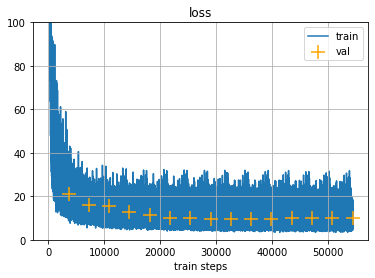

========== Epoch 15 ==========

Train loss: 9.708307266235352
Val loss: 9.885418891906738
CPU times: user 26min 27s, sys: 10.2 s, total: 26min 37s
Wall time: 26min 43s


In [27]:
%%time
# SELU
model = MyModel()
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) 
criterion = torch.nn.MSELoss(reduction='mean')

train_model(
    model=model, 
    optimizer=optimizer,
    criterion=criterion,
    train_loader=train_loader,
    test_loader=test_loader,
    n_epochs=15,
    ylim=(0,100)
)

# Sklearn RMSE = 11.48475891801073
# Torch RMSE = 11.484758377075195

In [28]:
get_real_predict()

100%|██████████| 51630/51630 [00:57<00:00, 898.87it/s]

Sklearn RMSE = 11.48475891801073
Torch RMSE = 11.484758377075195


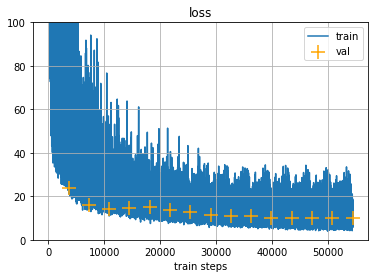

========== Epoch 15 ==========

Train loss: 10.508535385131836
Val loss: 10.240640640258789
CPU times: user 26min 26s, sys: 9.97 s, total: 26min 36s
Wall time: 26min 42s


In [30]:
%%time
# Leaky_RELU
model = MyModel()
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) 
criterion = torch.nn.MSELoss(reduction='mean')

train_model(
    model=model, 
    optimizer=optimizer,
    criterion=criterion,
    train_loader=train_loader,
    test_loader=test_loader,
    n_epochs=15,
    ylim=(0,100)
)

# Sklearn RMSE = 10.28418643842848
# Torch RMSE = 10.284186363220215

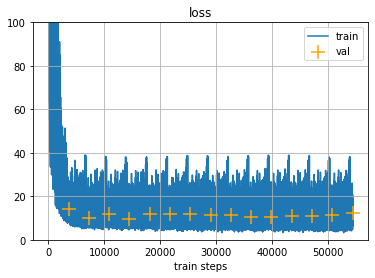

========== Epoch 15 ==========

Train loss: 11.181733131408691
Val loss: 12.212026596069336
CPU times: user 27min 27s, sys: 11.9 s, total: 27min 39s
Wall time: 27min 44s


In [20]:
%%time
# PRELU
model = MyModel()
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.003) 
criterion = torch.nn.MSELoss(reduction='mean')

train_model(
    model=model, 
    optimizer=optimizer,
    criterion=criterion,
    train_loader=train_loader,
    test_loader=test_loader,
    n_epochs=15,
    ylim=(0,100)
)

## Задание 2. (0 баллов, но при невыполнении максимум за все задание &mdash; 0 баллов)

Напишите небольшой отчет о том, как вы добились полученного качества: какие средства использовали и какие эксперименты проводили. Подробно расскажите об архитектурах и значениях гиперпараметров, а также какие метрики на тесте они показывали. Чтобы отчет был зачтен, необходимо привести хотя бы 3 эксперимента.

In [ ]:
# YOUR CODE HERE (－.－)...zzzZZZzzzZZZ